In [26]:
import pandas as pd
import numpy as np
import os
import pickle

import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.utils import shuffle
from plsr import PLSRComponents
from plsr import validate_plot
from brokenaxes import brokenaxes

from preprocessing.dataset import DatasetSpectra

In [27]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [28]:
file_path = '../data/dataset_681.csv'
domain_path = '../data/domain2.csv'

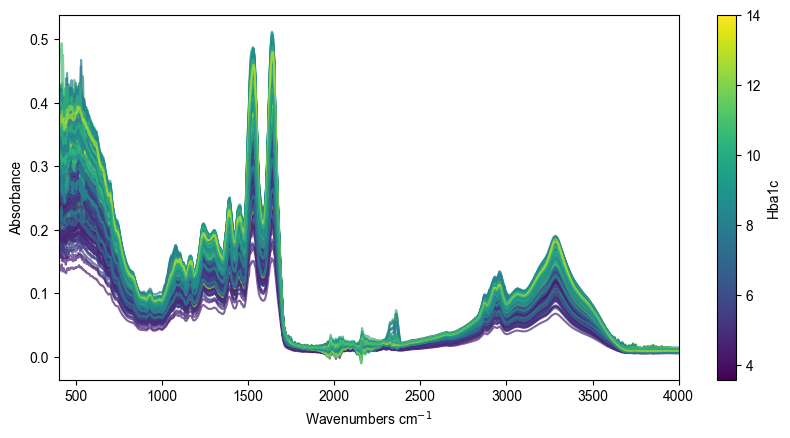

In [29]:
dataset = DatasetSpectra(file_path, domain_path)
dataset.select_max_hba1c(14)
dataset.select_region([400, 4000])
dataset.drop_samples([287, 636])
fig1, ax1 = dataset.plot_spectra()
plt.subplots_adjust(bottom=0.15)
plt.savefig('../figures/spectra_before_preproc.png', dpi=300, transparent=True)

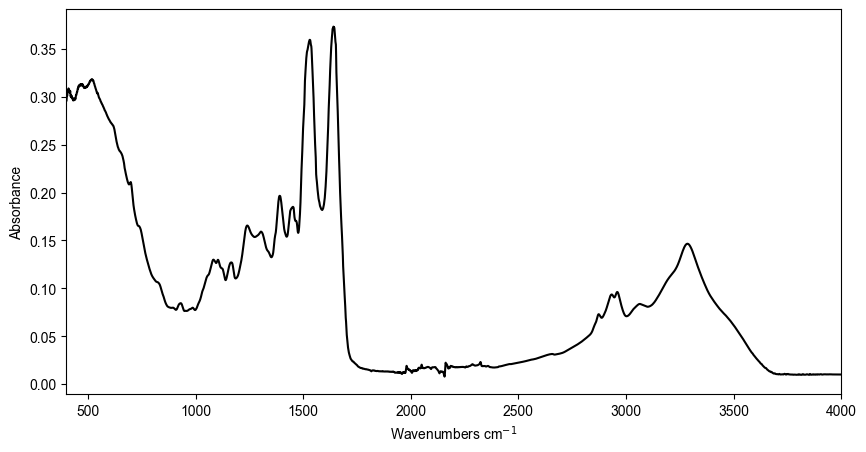

In [30]:
plt.figure(figsize=(10, 5))

spectra = dataset.spectra.mean(axis=0)
wn = dataset.wavenumbers
plt.plot(wn, spectra, color='k')
plt.xlabel("Wavenumbers cm$^{-1}$")
plt.ylabel("Absorbance")
plt.xlim([400, 4000])
plt.savefig('../figures/mean_spectra_before.png', dpi=300, transparent=True)

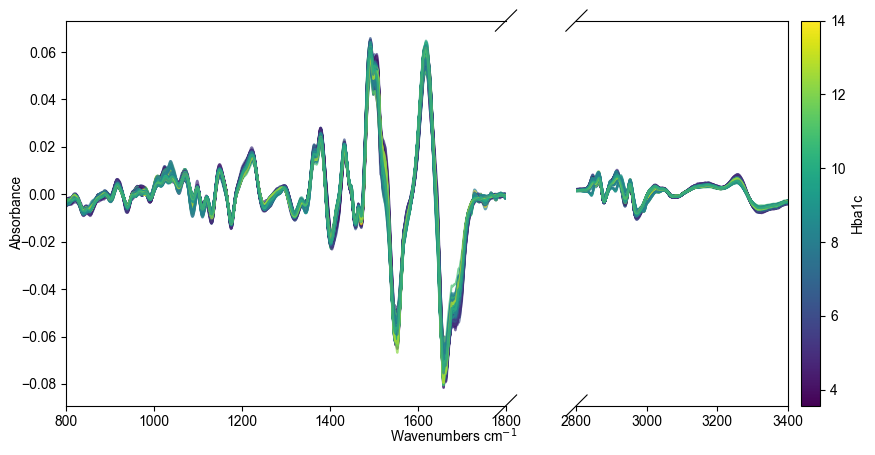

In [31]:
# dataset.baseline_corr()
dataset.savgol_filter(window_length=32, polyorder=2, deriv=1)
dataset.normalization('vector')
dataset.select_region([[800, 1800], [2800, 3400]])
# dataset.select_region([800, 1800])
fig2, ax2 = dataset.plot_spectra()
plt.savefig('../figures/spectra_after_preproc.png', dpi=300, transparent=True)

(<Figure size 1000x500 with 2 Axes>,
 <Axes: xlabel='Wavenumbers cm$^{-1}$', ylabel='Absorbance'>)

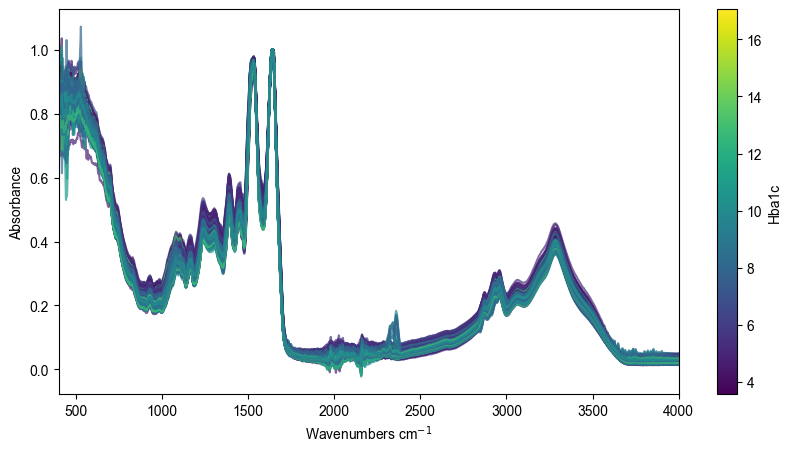

In [32]:
dataset = DatasetSpectra(file_path, domain_path)
dataset.normalization(kind='amide')
dataset.select_region([400, 4000])

spectra = dataset.spectra
wavenumbers = dataset.wavenumbers
hba1c = dataset.hba1c

dataset.plot_spectra()

In [33]:
spectra.shape

(681, 7466)

In [34]:
hba1c.shape

(681,)

In [35]:
df_spectra = pd.DataFrame(spectra)
df_spectra['HbA1c'] = hba1c

In [36]:
q25, q75 = np.percentile(hba1c, [25, 75])

print("Q1:", q25, "Q3:", q75)

hba1c_q25 = hba1c <= q25
hba1c_q75 = hba1c >= q75

Q1: 5.3 Q3: 8.93


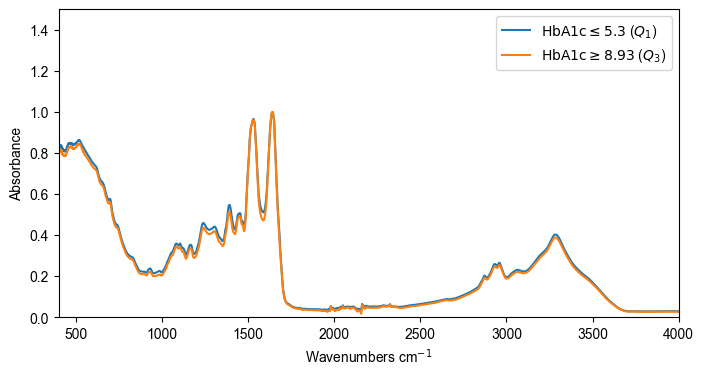

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(wavenumbers, spectra[hba1c_q25].mean(axis=0), label=r'$\text{HbA1c} \leq 5.3$ ($Q_1$)')
plt.plot(wavenumbers, spectra[hba1c_q75].mean(axis=0), label=r'$\text{HbA1c} \geq 8.93$ ($Q_3$)')

plt.xlabel("Wavenumbers cm$^{-1}$")
plt.ylabel("Absorbance")
plt.xlim([400, 4000])
plt.ylim([0.0, 1.5])
plt.legend()

plt.savefig("../figures/mean_spectra_hba1c.png", dpi=300, transparent=True)

In [38]:
df = pd.read_csv(file_path)

In [39]:
(df['HbA1c'] >= 8.93).sum()

np.int64(171)

In [40]:
(df['HbA1c'] <= 5.3).sum()

np.int64(171)

In [41]:
all_varimp = pd.read_csv('../data/curvefit_results/top_varimp_height.csv')
all_varimp

,variable,relative_importance,scaled_importance,percentage,model_id
0,1574,3217.007080,1.000000,0.212491,GBM_grid_1_AutoML_4_20250304_202826_model_1
1,1366,1823.856201,0.566942,0.120470,GBM_grid_1_AutoML_4_20250304_202826_model_1
2,1402,1514.088257,0.470651,0.100009,GBM_grid_1_AutoML_4_20250304_202826_model_1
3,1011,1042.744995,0.324135,0.068876,GBM_grid_1_AutoML_4_20250304_202826_model_1
4,1030,444.000305,0.138017,0.029327,GBM_grid_1_AutoML_4_20250304_202826_model_1
...,...,...,...,...,...
195,1011,0.280444,0.631467,0.040263,GLM_1_AutoML_4_20250304_202826
196,1051,0.242421,0.545852,0.034804,GLM_1_AutoML_4_20250304_202826
197,1574,0.233071,0.524799,0.033462,GLM_1_AutoML_4_20250304_202826
198,1313,0.206001,0.463847,0.029575,GLM_1_AutoML_4_20250304_202826


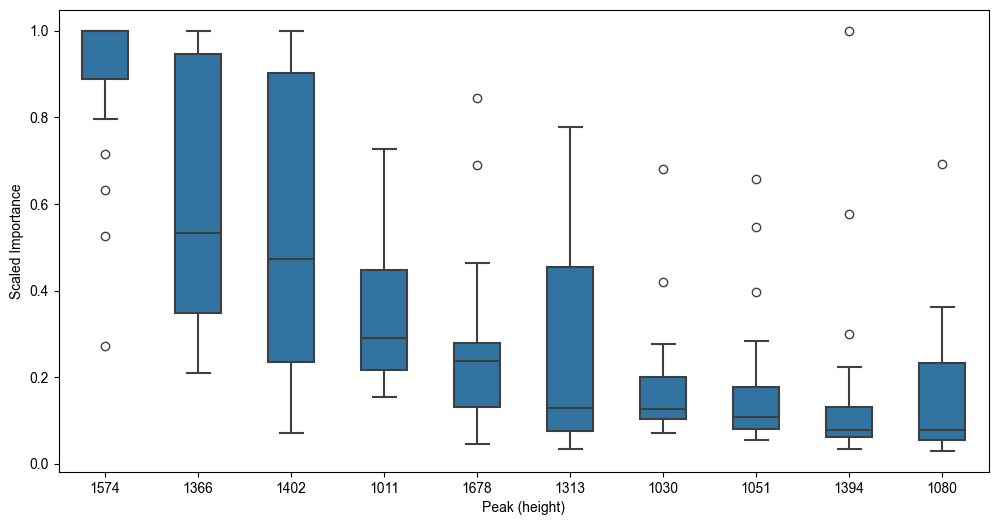

In [42]:
top_features = all_varimp.groupby('variable')['scaled_importance'].mean().nlargest(10).index

top_varimp = all_varimp[all_varimp['variable'].isin(top_features)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='variable', y='scaled_importance', 
            data=top_varimp, 
            order=top_features, linewidth=1.5, width=0.5)
# plt.title('Top 10 Most Important Features Across Models')
plt.ylabel('Scaled Importance')
plt.xlabel("Peak (height)")
plt.savefig("../figures/top_varimp_height.png", transparent=True, dpi=300)

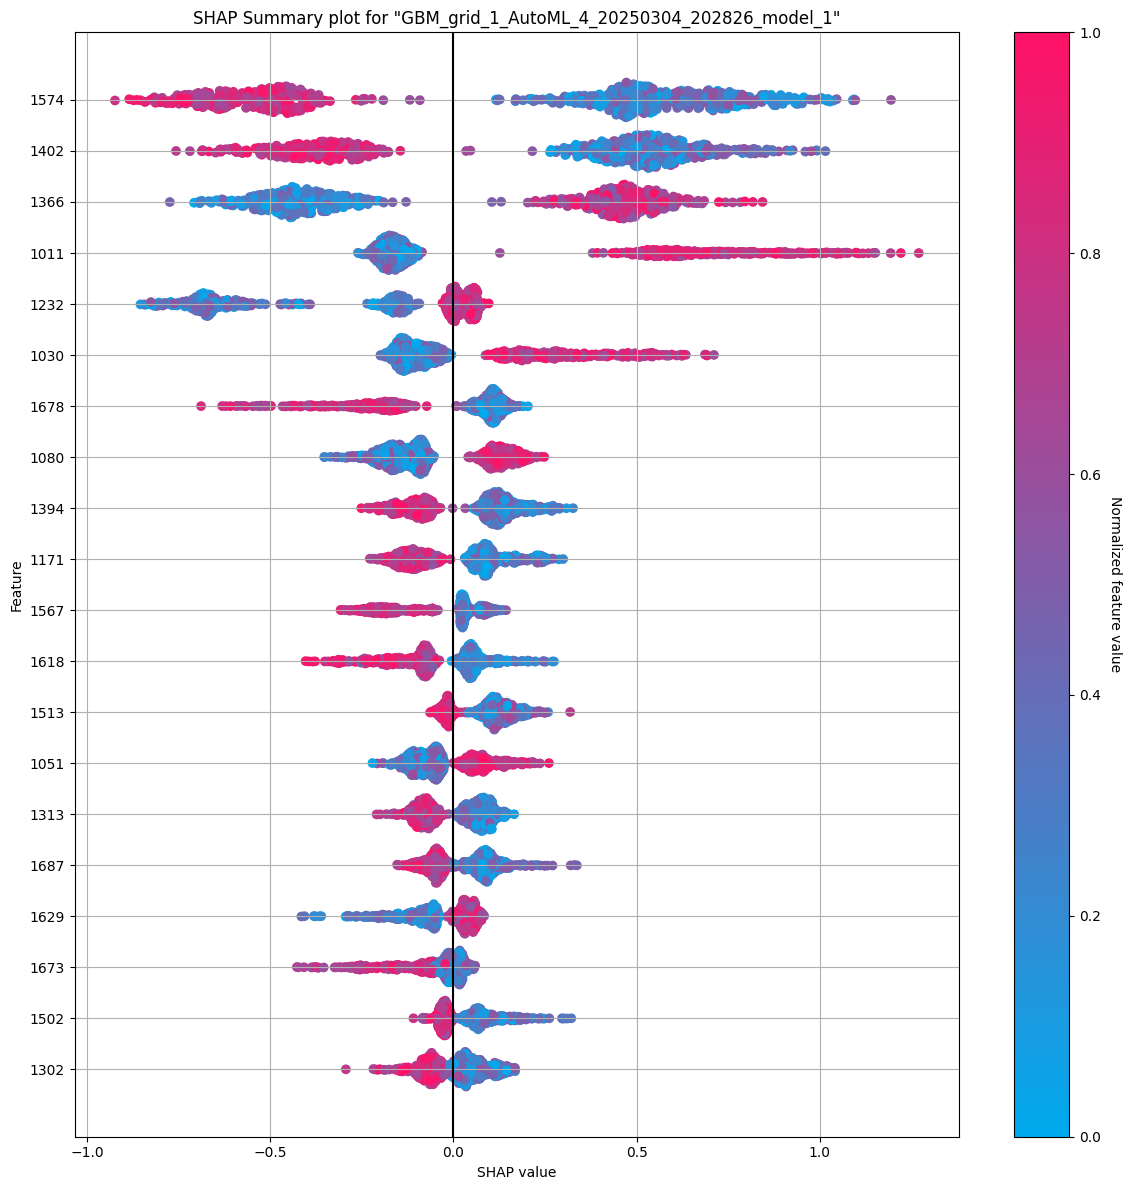

In [43]:
with open("../data/curvefit_results/SHAP_height.pkl", "rb") as f:
    shap_height = pickle.load(f)
plt.savefig('../figures/SHAP_height.png', transparent=True, dpi=300)

In [44]:
res = pd.read_csv('../data/curvefit_results/predict_curvefit_height.csv')
y_true, y_pred_cf = res.T.to_numpy()

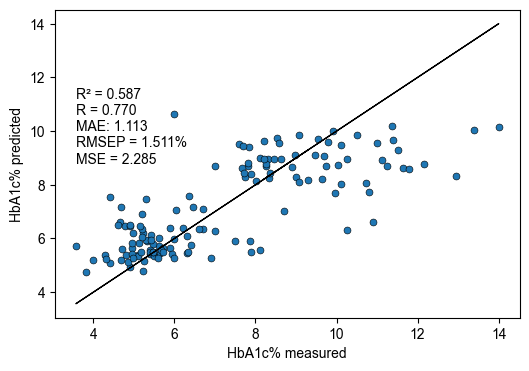

In [45]:
fig, ax = validate_plot(y_true, y_pred_cf)
plt.savefig("../figures/validation_curvefit.png", transparent=True, dpi=300)

In [55]:
data_cnn = np.load('../data/predict_cnn.npy')
y_pred_cnn, y_true_cnn = data_cnn.T

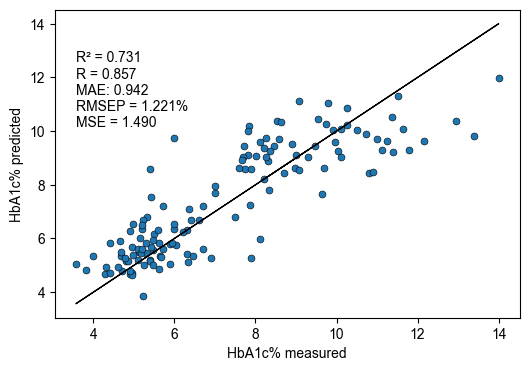

In [57]:
fig, ax = validate_plot(y_true_cnn, y_pred_cnn)
plt.savefig("../figures/validation_cnn.png", transparent=True, dpi=300)